In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
eps = 0.01
pc_ini = np.array([.1, .5, .9])
bs = np.array([9/8, 3/2, 31/20, 8/5, 9/5, 2, 8/3]) + eps
seeds = np.array([i for i in range(1, 101)])
n = len(seeds)
m = len(bs)
L = 60
burn = 1000 * L * L
evol = 1000 * L * L

In [3]:
def make_field(size, pc_initial):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - size - размер поля
    - pc_initial - начальная плотность кооператоров
    
    возвращает
    - field - поле по заданным начальным условиям, где 1 - дефектор, 0 - кооператор
    
    ---------------------------------------
    '''
    field = np.array(np.random.rand(size, size) > pc_initial, dtype=int)
    return field

def evolve(field, b, steps):
    '''
    ---Эволюция поля---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    for step in range(steps):
        scorex = 0
        xi, xj = np.random.randint(0, L, 2)
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (xi + i) % L
                tj = (xj + j) % L
                if field[ti, tj] == 0:
                    scorex += 1
        if field[xi, xj] == 1:
            scorex *= b
        
        scorey = 0
        yi, yj = np.random.randint(-1, 2, 2)
        yi = (yi + xi) % L
        yj = (yj + xj) % L
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (yi + i) % L
                tj = (yj + j) % L
                if field[ti, tj] == 0:
                    scorey += 1
        if field[yi, yj] == 1:
            scorey *= b
        if scorey > scorex:
            field[xi, xj] = field[yi, yj]
            
def calculate_pc(size, pc_initial, b, burn_steps, evol_steps, seed):
    '''
    ---Вычисление плотности кооператоров---
    
    принимает на вход
    - size
    - pc_initial
    - b
    - burn_steps - шаги отжига
    - evol_steps - шаги эволюции
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - pc - плотность кооператоров на протяжении evol_steps шагов
    
    ---------------------------------------
    '''
    np.random.seed(seed)
    pc = np.zeros(evol_steps)
    field = make_field(size, pc_initial)
    evolve_C(field, b, burn_steps, seed)
    for step in range(evol_steps):
        evolve_C(field, b, 1, seed)
        pc[step] = np.count_nonzero(field - 1) / (size * size)
    
    return pc

In [4]:
%load_ext cython

In [5]:
%%cython -a
import numpy as np
import cython
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)

def evolve_C_np(int[:, :] field, double b, int steps):
    '''
    ---Эволюция поля на Cython с numpy.random---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    
    # обьявление переменных
    
    cdef int step, xi, xj, i, j, ti, tj, yi, yj
    
    cdef int L = field.shape[0]
    
    cdef double scorex, scorey
    
    
    for step in range(steps):
        scorex = 0
        xi, xj = np.random.randint(0, L, 2)
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (xi + i + L) % L
                tj = (xj + j + L) % L
                if field[ti, tj] == 0:
                    scorex += 1
        if field[xi, xj] == 1:
            scorex *= b
        
        scorey = 0
        yi, yj = np.random.randint(-1, 2, 2)
        yi = (yi + xi + L) % L
        yj = (yj + xj + L) % L
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (yi + i + L) % L
                tj = (yj + j + L) % L
                if field[ti, tj] == 0:
                    scorey += 1
        if field[yi, yj] == 1:
            scorey *= b
        if scorey > scorex:
            field[xi, xj] = field[yi, yj]
            

In [6]:
# проверка, что результаты идентичны

field = make_field(L, 0.9)
field_2 = field.copy()

seed = 1
np.random.seed(seed)
evolve_C_np(field, 1.3, 1000)

np.random.seed(seed)
evolve(field_2, 1.3, 1000)

(abs(field - field_2)).sum()

0

In [7]:
%%cython -a
import cython
import numpy as np
from rndm_wrapper cimport RndmWrapper
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)

def evolve_C(int[:, :] field, double b, int steps, int seed):
    '''
    ---Эволюция поля на Cython с RndmWrapper---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша
    - steps - количество шагов эволюции. За один шаг происходит эволюция одного случайного агента
    
    -------------------
    '''
    
    # обьявление переменных
    
    cdef int step, xi, xj, i, j, ti, tj, yi, yj
    
    cdef int L = field.shape[0]
    
    cdef double scorex, scorey
    
    cdef RndmWrapper rndm = RndmWrapper(seed=(seed, 0))
    
    for step in range(steps):
        scorex = 0
        xi = int(rndm.uniform() * L)
        xj = int(rndm.uniform() * L)
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (xi + i + L) % L
                tj = (xj + j + L) % L
                if field[ti, tj] == 0:
                    scorex += 1
        if field[xi, xj] == 1:
            scorex *= b
        
        scorey = 0
        yi = int(rndm.uniform() * 3)
        yj = int(rndm.uniform() * 3)
        yi -= 1
        yj -= 1
        yi = (yi + xi + L) % L
        yj = (yj + xj + L) % L
        for i in range(-1, 2):
            for j in range(-1, 2):
                ti = (yi + i + L) % L
                tj = (yj + j + L) % L
                if field[ti, tj] == 0:
                    scorey += 1
        if field[yi, yj] == 1:
            scorey *= b
        if scorey > scorex:
            field[xi, xj] = field[yi, yj]
            

In [8]:
%timeit evolve(field, 1.3, 1000)

55.4 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit evolve_C_np(field, 1.3, 1000)

20.8 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit evolve_C(field, 1.3, 1000, 1)

216 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Для исследования модификации игры на данном этапе необходимо для каждой начальной плотности кооператоров рассмотреть два графика:

1. График зависимости плотности от времени. Плотность усредняется по реализациям.
2. График зависимости плотности от $b$. Плотность усредняется по времени и реализациям. Вычисляются стандартные ошибки среднего для каждого $b$.

### Стандартная ошибка среднего (по реализациям)

Вычисляется как $\frac{\sqrt{\frac{1}{n}\sum\limits_{j=1}^n{(\rho_j - \overline{\rho})}^2}}{\sqrt{n}}$, где

$\rho_j$ - значение плотности по шагам для одной реализации

$\overline{\rho}$ - среднее значение плотности по шагам и по реализациям

$n$ - количество реализаций

# ${\rho_c}_{ini} = 0.9$

In [11]:
pc2 = np.zeros((m, evol))
err2 = np.zeros(m)
p_tilda2 = np.zeros(m)
for i in range(m):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[2], bs[i], burn, evol, seeds[j])
    pc2[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda2[i] = np.mean(pc_temp)
    err2[i] = np.sqrt((sum(p_j - p_tilda2[i]) ** 2) / n) / np.sqrt(n)

In [19]:
for pc in pc2:
    print(pc)

[0.99551389 0.99551389 0.99551389 ... 0.99551389 0.99551389 0.99551389]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [20]:
for err in err2:
    print(err)

9.654499422140362e-15
0.0
0.0
0.0
0.0
0.0
0.0


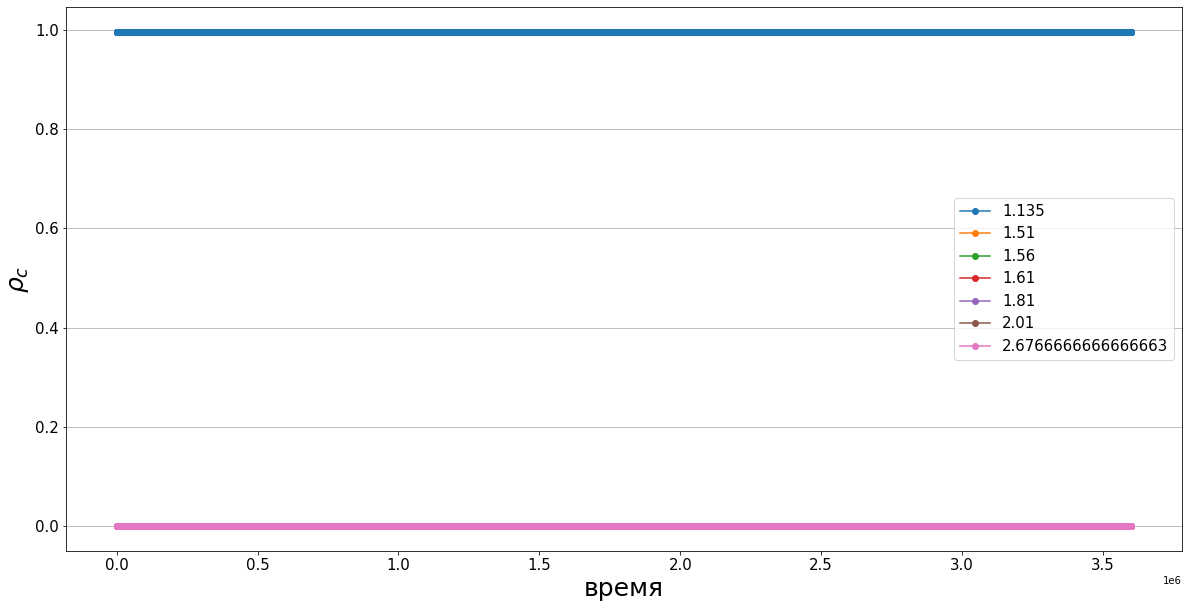

In [12]:
#График зависимости плотности от количества шагов эволюции
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(m):
    ax.plot(pc2[i], 'o-', label=bs[i])

ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

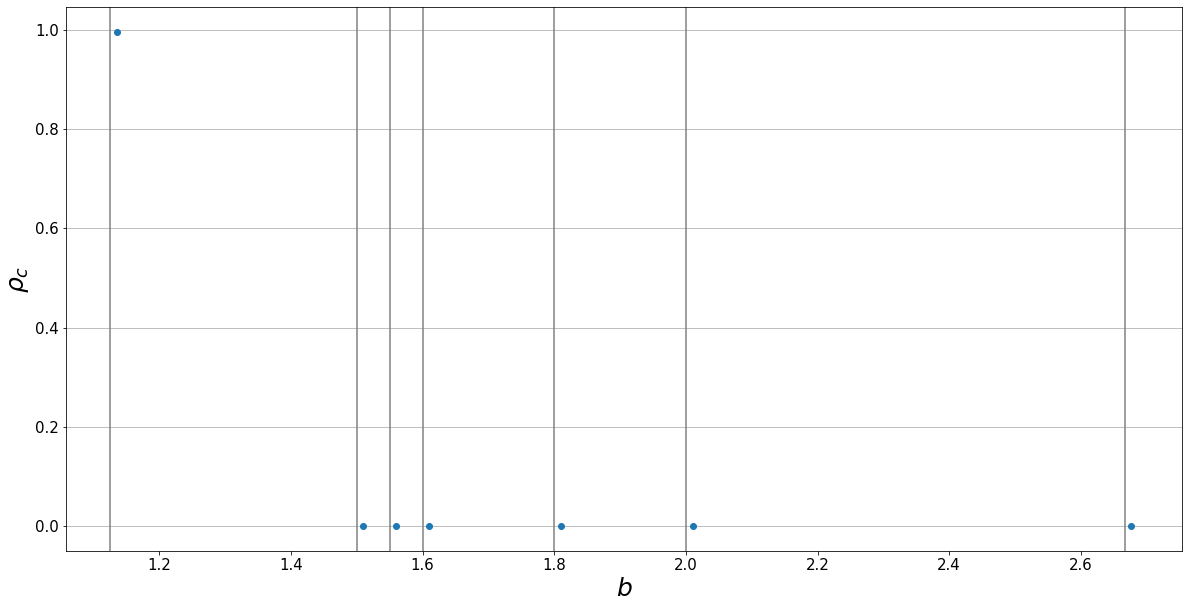

In [13]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs, p_tilda2, err2, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m):
    ax.axvline(bs[i] - eps, color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

# ${\rho_c}_{ini} = 0.1$

In [14]:
pc0 = np.zeros((m, evol))
err0 = np.zeros(m)
p_tilda0 = np.zeros(m)
for i in range(m):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[0], bs[i], burn, evol, seeds[j])
    pc0[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda0[i] = np.mean(pc_temp)
    err0[i] = np.sqrt((sum(p_j - p_tilda0[i]) ** 2) / n) / np.sqrt(n)

KeyboardInterrupt: 

In [ ]:
#График зависимости плотности от количества шагов эволюции
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(m):
    ax.plot(pc0[i], 'o-', label=bs[i])

ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

In [ ]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs, p_tilda0, err0, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m):
    ax.axvline(bs[i] - eps, color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

# ${\rho_c}_{ini} = 0.5$

In [ ]:
pc1 = np.zeros((m, evol))
err1 = np.zeros(m)
p_tilda1= np.zeros(m)
for i in range(m):
    pc_temp = np.zeros((n, evol))
    for j in range(n):
        pc_temp[j] = calculate_pc(L, pc_ini[1], bs[i], burn, evol, seeds[j])
    pc1[i] = np.mean(pc_temp, axis=0)
    
    p_j = np.mean(pc_temp, axis=1)
    p_tilda1[i] = np.mean(pc_temp)
    err1[i] = np.sqrt((sum(p_j - p_tilda1[i]) ** 2) / n) / np.sqrt(n)

In [ ]:
#График зависимости плотности от количества шагов эволюции
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(m):
    ax.plot(pc1[i], 'o-', label=bs[i])

ax.set_xlabel('время',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

In [ ]:
#График зависимости плотности от b
fig,ax = plt.subplots(1, 1, figsize=(20, 10))
ax.errorbar(bs, p_tilda1, err1, fmt='o', capsize=3)
ax.set_xlabel('$%s$'%'b',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c',fontsize=25)
for i in range(m):
    ax.axvline(bs[i] - eps, color='grey')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')